In [32]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
import time
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
import shap


In [33]:
df = pd.read_csv('SAdata_allMeasures.csv')

print(df.isnull().sum())

y = df['Y']
X = df.drop(columns=['Y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
df.head()

age                      0
gender                   0
yearDriving              0
drivingFrequency         0
temp_length              0
temp_decisiontime        0
temp_decision_made       0
temp_correct_decision    0
temp_danger              0
temp_difficulty          0
CarPlacedLeft            0
CarPlacedRight           0
numS                     0
sAmpMean                 0
sAmpStd                  0
sAmpMax                  0
numF                     0
fMean                    0
fStd                     0
fMax                     0
backMirror               0
leftMirror               0
rightMirror              0
road                     0
sky                      0
pupilChange              0
pupilMean                0
pupilStd                 0
Y                        0
dtype: int64
(843, 28)


,age,gender,yearDriving,drivingFrequency,temp_length,temp_decisiontime,temp_decision_made,temp_correct_decision,temp_danger,temp_difficulty,...,fMax,backMirror,leftMirror,rightMirror,road,sky,pupilChange,pupilMean,pupilStd,Y
0,26,1,20,1,12,4.80219,4,2,20,89,...,874.5,0,5,3,24,0,0.733955,3.818149,0.169227,0.641219
1,26,1,20,1,6,4.91667,1,2,10,99,...,1014.0,2,2,1,9,2,0.623622,3.743575,0.178412,0.354868
2,26,1,20,1,1,2.21716,2,2,99,99,...,259.5,0,0,0,3,0,0.205836,3.326857,0.079828,0.561225
3,26,1,20,1,3,2.63056,1,2,9,79,...,636.0,0,1,0,6,0,0.020505,3.643468,0.034005,0.422067
4,26,1,20,1,9,2.42632,1,2,9,96,...,807.0,5,4,1,13,0,0.632357,3.669544,0.196699,0.533333


## Preprocessing

Since many features have different


In [34]:
from sklearn.preprocessing import StandardScaler

#from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



## Baseline LR


In [35]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

start_lr = time.time()
linear_model.fit(X_train, y_train)
end_lr = time.time()

linear_predictions = linear_model.predict(X_test)

linear_mse = mean_squared_error(y_test, linear_predictions)
print("Linear Regression Mean Squared Error:", linear_mse)

linear_r2 = r2_score(y_test, linear_predictions)
print("Linear Regression R-squared:", linear_r2)

print("Linear Regression Time:", end_lr - start_lr)

Linear Regression Mean Squared Error: 0.013088468386775068
Linear Regression R-squared: 0.2266474649334408
Linear Regression Time: 0.0008335113525390625


## XGB


In [36]:
#https://stackoverflow.com/questions/68766331/how-to-apply-predict-to-xgboost-cross-validation
#https://xgboost.readthedocs.io/en/latest/python/examples/cross_validation.html

dtrain = xgb.DMatrix(X, label=y) 
#https://stackoverflow.com/questions/70127049/what-is-the-use-of-dmatrix

params = {
    "max_depth": 3, 
    "eta": 0.1,
    "objective": "reg:squarederror",
    "verbosity": 0
}


results = xgb.cv(
    params,
    dtrain,
    num_boost_round=100,
    nfold=5,
    metrics=['rmse', 'mae'],
    early_stopping_rounds=10,
    callbacks=[xgb.callback.EvaluationMonitor()], #https://xgboosting.com/how-to-use-xgboost-evaluationmonitor-callback/
    seed=42,
    verbose_eval=False
)

start_time_xgb = time.time()
model_xgb = xgb.train(params, dtrain, num_boost_round=100)
stop_time_xgb = time.time()



gbm_train_time = stop_time_xgb - start_time_xgb

gbm_rsme = results['test-rmse-mean']
gbm_mae = results['test-mae-mean']

gbm_rsme_train = results['train-rmse-mean']
gbm_mae_train = results['train-mae-mean']




[0]	train-rmse:0.13186	train-mae:0.10794	test-rmse:0.13207	test-mae:0.10823
[1]	train-rmse:0.12880	train-mae:0.10524	test-rmse:0.12942	test-mae:0.10582
[2]	train-rmse:0.12616	train-mae:0.10286	test-rmse:0.12740	test-mae:0.10389
[3]	train-rmse:0.12373	train-mae:0.10073	test-rmse:0.12559	test-mae:0.10223
[4]	train-rmse:0.12160	train-mae:0.09882	test-rmse:0.12425	test-mae:0.10092
[5]	train-rmse:0.11970	train-mae:0.09709	test-rmse:0.12290	test-mae:0.09963
[6]	train-rmse:0.11795	train-mae:0.09546	test-rmse:0.12164	test-mae:0.09842
[7]	train-rmse:0.11650	train-mae:0.09406	test-rmse:0.12066	test-mae:0.09743
[8]	train-rmse:0.11505	train-mae:0.09271	test-rmse:0.11967	test-mae:0.09649
[9]	train-rmse:0.11381	train-mae:0.09159	test-rmse:0.11893	test-mae:0.09569
[10]	train-rmse:0.11270	train-mae:0.09056	test-rmse:0.11818	test-mae:0.09502
[11]	train-rmse:0.11158	train-mae:0.08950	test-rmse:0.11759	test-mae:0.09438
[12]	train-rmse:0.11053	train-mae:0.08852	test-rmse:0.11696	test-mae:0.09377
[13]	trai

# LGB


In [37]:
params = {
    'objective': 'regression',
    'num_leaves': 20,              # Smaller for small dataset
    'learning_rate': 0.1,          # Slightly higher
    'min_data_in_leaf': 5,         # Smaller for small dataset
    'bagging_freq': 5,
    'lambda_l1': 0.1,              # Some regularization
    'metric': ['rmse', 'mae'],
    'verbose': -1,
}

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test)

#https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.htmlxw
#https://stackoverflow.com/questions/49774825/how-to-use-lightgbm-cv-for-regression

# Store evaluation history
evals_result = {}
record_eval = lgb.record_evaluation(evals_result)
early_stopping_callback = lgb.early_stopping(5, first_metric_only=False, verbose=False)

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=100,#This is a deault value however early stopping will stop earlier
    nfold=10, #As specified in the assignment
    callbacks=[record_eval, early_stopping_callback],
    stratified=False, #LGBM does not support stratified for regression 
    eval_train_metric=True, 
    seed=42
)


start_time_lgb = time.time()
model_lgb = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, valid_data],
    callbacks=[early_stopping_callback],
)
stop_time_lgb = time.time()


############    Results    ############
lgb_train_time = stop_time_lgb - start_time_lgb

lgb_train_rmse = evals_result['train']['rmse-mean']
lgb_train_mae = evals_result['train']['l1-mean']

lgb_valid_rmse = evals_result['valid']['rmse-mean']
lgb_valid_mae = evals_result['valid']['l1-mean']

## LGB Distributed


In [38]:
params = {
        'objective': 'regression',
        'metric': ['rmse', 'mae'],
        'num_leaves': 20,           
        'learning_rate': 0.1,     
        'min_data_in_leaf': 5,    
        'bagging_freq': 5,
        'verbose': -1,
        # Distributed settings
        'num_threads': 8,
        'tree_learner': 'feature', 
        'force_row_wise': True
    }

train_data = lgb.Dataset(X_train, label=y_train)
validation_data = lgb.Dataset(X_test, label=y_test)


# Store evaluation history
evals_result_distributed = {}
record_eval = lgb.record_evaluation(evals_result)
early_stopping_callback = lgb.early_stopping(5, first_metric_only=False, verbose=False)


stop_time_lgb = time.time()
model_lgb_distributed = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, validation_data],
    num_boost_round=100,
    callbacks=[record_eval, early_stopping_callback]
)
stop_time_lgb = time.time()


cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=100,
    nfold=10,
    callbacks=[record_eval, early_stopping_callback],
    stratified=False, 
    eval_train_metric=True, 
    seed=42
)

print(evals_result)

############    Results    ############
lgb_train_time = stop_time_lgb - start_time_lgb

lgb_train_rmse_disributed = evals_result['train']['rmse-mean']
lgb_train_mae_disributed = evals_result['train']['l1-mean']

lgb_valid_rmse_disributed = evals_result['valid']['rmse-mean']
lgb_valid_mae_disributed = evals_result['valid']['l1-mean']


{'train': OrderedDict({'rmse-mean': [0.13123655695005376, 0.12636338767644512, 0.12208244277586848, 0.11816580120667979, 0.11456946718547205, 0.1112762335928664, 0.10832052197110453, 0.10558277119236811, 0.10309592743713761, 0.10077272571448662, 0.09854040311888539, 0.09651085015533048, 0.09463367580222458, 0.09278016228387627, 0.09104309298840801, 0.08937552632461339, 0.08772377798285479, 0.0860830799891302, 0.08461303344318971, 0.08310039707431233, 0.08169631616028193, 0.08029698113273397, 0.07896059405360353, 0.07768888931751702, 0.07645686242129462, 0.07525124610518372], 'rmse-stdv': [0.0011465918854940804, 0.0010759974487911702, 0.0010477752639457877, 0.0011698595562468727, 0.0010011210680266824, 0.000977591366869282, 0.0008682739242671789, 0.0009049364080875358, 0.0008572608074648943, 0.0008311088940553281, 0.0008439966178130009, 0.0008912249804684375, 0.0009250903594596829, 0.0008542609181597745, 0.0007948190620165368, 0.0007974899895332437, 0.0007939740853474906, 0.000863474301

## REPORT


In [39]:
#Code in this cell is mostly genareted with the help of an LLM.
def plot_split_metrics(metrics_dict):
    """
    Plot training and validation metrics in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))
    
    # Color palette - same base color with different shades for each model
    colors = {
        'LightGBM': {
            'rmse': '#1a53ff',  # Darker blue
            'mae': '#668cff'    # Lighter blue
        },
        'XGBoost': {
            'rmse': '#ff1a1a',  # Darker red
            'mae': '#ff6666'    # Lighter red
        },
        'Distributed LightGBM': {
            'rmse': '#00cc00',  # Darker green
            'mae': '#66ff66'    # Lighter green
        }
    }
    
    # Training metrics plot
    for model_name, metrics in metrics_dict.items():
        color_dict = colors[model_name]
        
        # Plot training metrics
        ax1.plot(metrics['train_rmse'], label=f'{model_name} RMSE', 
                color=color_dict['rmse'], linewidth=2)
        ax1.plot(metrics['train_mae'], label=f'{model_name} MAE', 
                color=color_dict['mae'], linewidth=2)
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel('Iterations', fontsize=12)
    ax1.set_ylabel('Error', fontsize=12)
    ax1.set_title('Training Metrics', fontsize=14, pad=15)
    ax1.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    ax1.set_facecolor('#f8f9fa')
    
    # Validation metrics plot
    for model_name, metrics in metrics_dict.items():
        color_dict = colors[model_name]
        
        # Plot validation metrics
        ax2.plot(metrics['valid_rmse'], label=f'{model_name} RMSE', 
                color=color_dict['rmse'], linewidth=2)
        ax2.plot(metrics['valid_mae'], label=f'{model_name} MAE', 
                color=color_dict['mae'], linewidth=2)
    
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel('Iterations', fontsize=12)
    ax2.set_ylabel('Error', fontsize=12)
    ax2.set_title('Validation Metrics', fontsize=14, pad=15)
    ax2.legend(frameon=True, fancybox=True, shadow=True, fontsize=10)
    ax2.set_facecolor('#f8f9fa')
    
    plt.tight_layout()
    return fig

def print_final_values(metrics_dict):
    for model_name, metrics in metrics_dict.items():
        print(f"\n{model_name}:")
        print(f"Valid RMSE: {metrics['valid_rmse'].iloc[-1]:.4f}")
        print(f"Valid MAE: {metrics['valid_mae'].iloc[-1]:.4f}")


XGBoost:
Valid RMSE: 0.1112
Valid MAE: 0.0875

LightGBM:
Valid RMSE: 0.1150
Valid MAE: 0.0895

Distributed LightGBM:
Valid RMSE: 0.1158
Valid MAE: 0.0902
Linear Regression Prediction Time: 0.0001 seconds
LightGBM Prediction Time: 0.0034 seconds
Distributed LightGBM Prediction Time: 0.0088 seconds
XGBoost Prediction Time: 0.0148 seconds
XGBoost Training Time: 0.0292 seconds
LightGBM Training Time: 3.5137 seconds
Distributed LightGBM Training Time: 3.5137 seconds


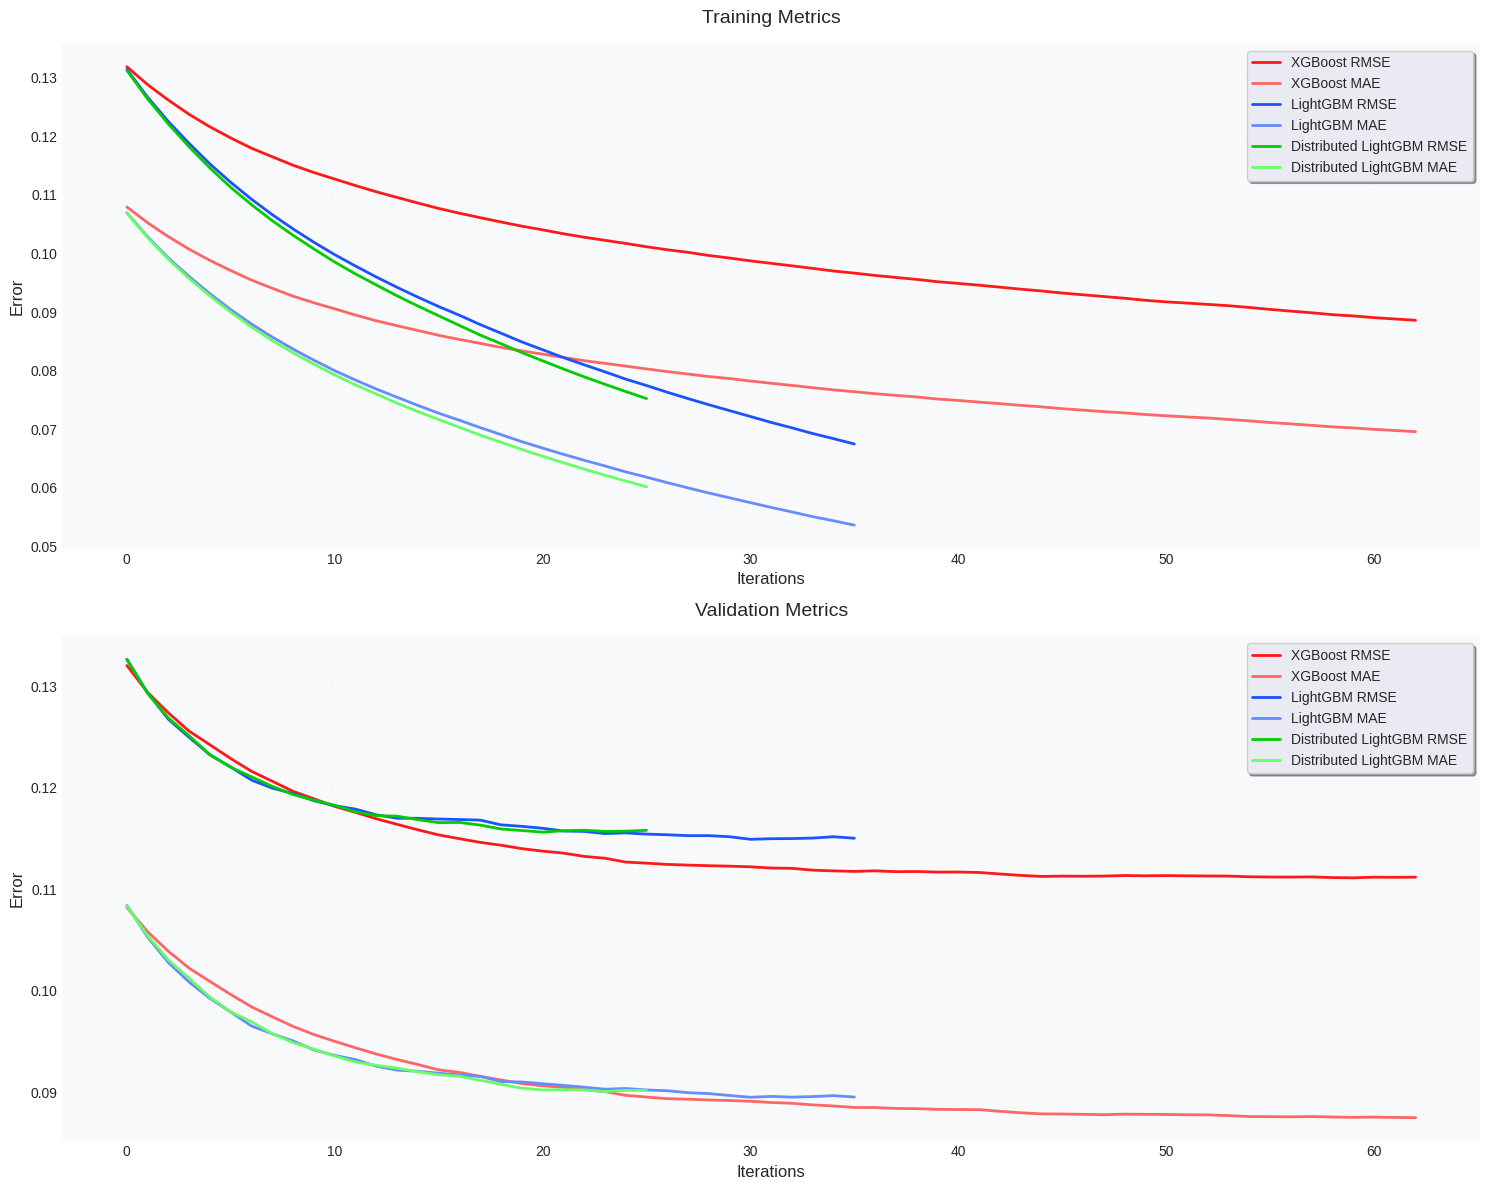

In [40]:
# Ensure the feature names are consistent
feature_names = X.columns

# GBM provides different data types for metrics
metrics_dict = {
    'XGBoost': {
        'train_rmse': pd.Series(gbm_rsme_train),
        'train_mae': pd.Series(gbm_mae_train),
        'valid_rmse': pd.Series(gbm_rsme),
        'valid_mae': pd.Series(gbm_mae)
    },
    'LightGBM': {
        'train_rmse': pd.Series(lgb_train_rmse),
        'train_mae': pd.Series(lgb_train_mae),
        'valid_rmse': pd.Series(lgb_valid_rmse),
        'valid_mae': pd.Series(lgb_valid_mae)
    },
    'Distributed LightGBM': {
        'train_rmse': pd.Series(lgb_train_rmse_disributed),
        'train_mae': pd.Series(lgb_train_mae_disributed),
        'valid_rmse': pd.Series(lgb_valid_rmse_disributed),
        'valid_mae': pd.Series(lgb_valid_mae_disributed)
    }
}

print_final_values(metrics_dict)
plot_split_metrics(metrics_dict)

# Report prediction time
start_time = time.time()
linear_predictions = linear_model.predict(X_test)
stop_time = time.time()
linear_pred_time = stop_time - start_time


start_time = time.time()
lgb_predictions = model_lgb.predict(X_test)
stop_time = time.time()
lgb_pred_time = stop_time - start_time

start_time = time.time()
lgb_predictions_distributed = model_lgb_distributed.predict(X_test)
stop_time = time.time()
lgb_pred_time_distributed = stop_time - start_time


dtest = xgb.DMatrix(df.drop(columns=['Y']))


start_time = time.time()
xgb_predictions = model_xgb.predict(dtest)
stop_time = time.time()


print(f"Linear Regression Prediction Time: {linear_pred_time:.4f} seconds")
print(f"LightGBM Prediction Time: {lgb_pred_time:.4f} seconds")
print(f"Distributed LightGBM Prediction Time: {lgb_pred_time_distributed:.4f} seconds")
print(f"XGBoost Prediction Time: {stop_time - start_time:.4f} seconds")

#train time
print(f"XGBoost Training Time: {gbm_train_time:.4f} seconds")
print(f"LightGBM Training Time: {lgb_train_time:.4f} seconds")
print(f"Distributed LightGBM Training Time: {lgb_train_time:.4f} seconds")





## SHAP


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


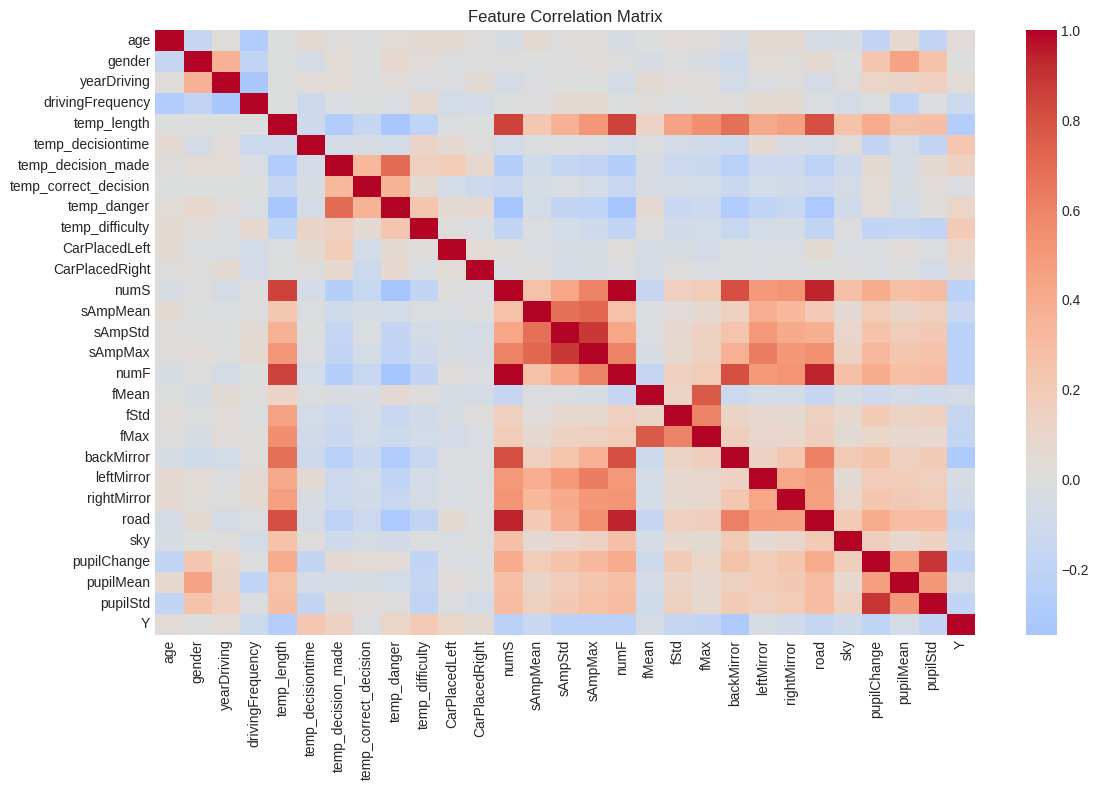

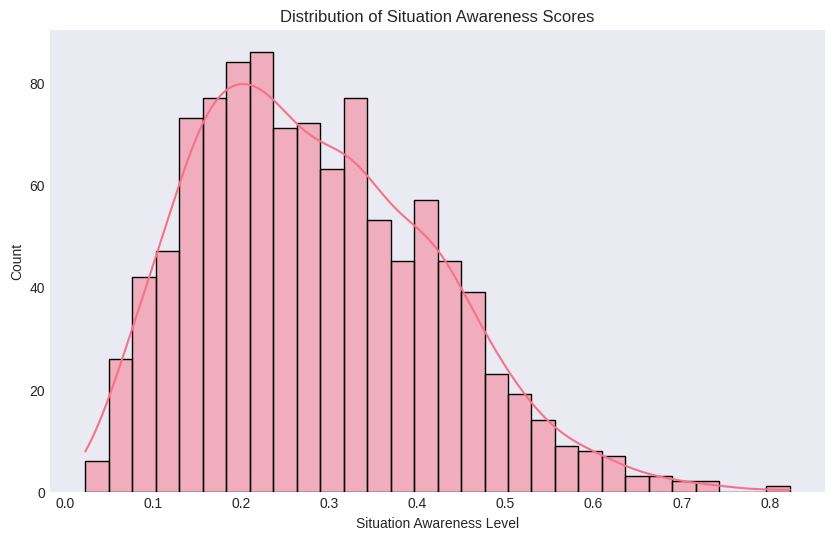

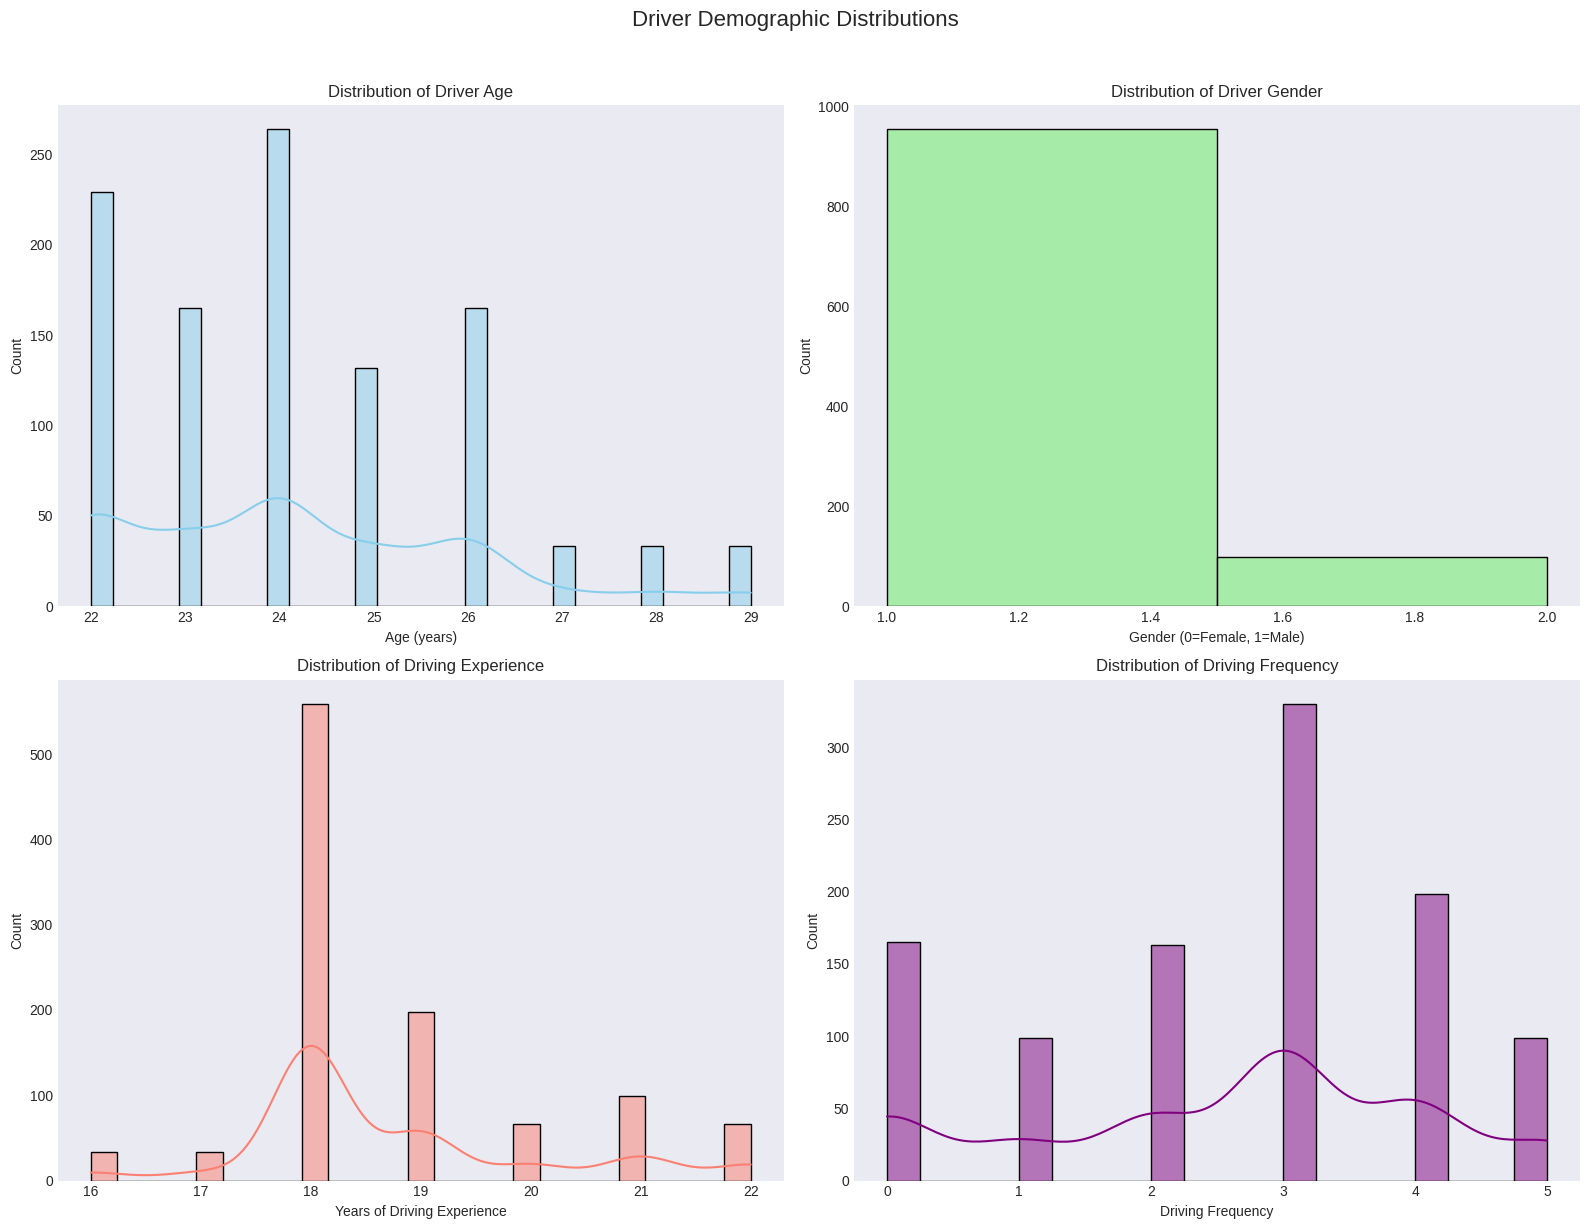

In [ ]:
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# Reimport for deeper analysis
df = pd.read_csv('SAdata_allMeasures.csv')

print(plt.style.available)
plt.style.use('seaborn-v0_8-dark')
sns.set_palette("husl")

# Create a figure for correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns,
            yticklabels=correlation_matrix.columns,
            cmap='coolwarm',
            center=0,
            annot=False)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Distribution of target variable
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Y', bins=30, kde=True)
plt.title('Distribution of Situation Awareness Scores')
plt.xlabel('Situation Awareness Level')
plt.ylabel('Count')
plt.show()

# Distribution of driver demographics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sns.histplot(data=df, x='age', bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Driver Age', fontsize=12)
axes[0, 0].set_xlabel('Age (years)', fontsize=10)
axes[0, 0].set_ylabel('Count', fontsize=10)

sns.histplot(data=df, x='gender', bins=2, kde=False, ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Distribution of Driver Gender', fontsize=12)
axes[0, 1].set_xlabel('Gender (0=Female, 1=Male)', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)
axes[0, 1].set_xticks([0, 1]) # The graph went from 0.0 to 2.0 without this

axes[0, 1].set_title('Distribution of Driver Gender', fontsize=12)
axes[0, 1].set_xlabel('Gender (0=Female, 1=Male)', fontsize=10)
axes[0, 1].set_ylabel('Count', fontsize=10)

sns.histplot(data=df, x='yearDriving', bins=25, kde=True, ax=axes[1, 0], color='salmon')
axes[1, 0].set_title('Distribution of Driving Experience', fontsize=12)
axes[1, 0].set_xlabel('Years of Driving Experience', fontsize=10)
axes[1, 0].set_ylabel('Count', fontsize=10)

sns.histplot(data=df, x='drivingFrequency', bins=20, kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Distribution of Driving Frequency', fontsize=12)
axes[1, 1].set_xlabel('Driving Frequency', fontsize=10)
axes[1, 1].set_ylabel('Count', fontsize=10)

fig.suptitle('Driver Demographic Distributions', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()




In [42]:
X_test_df = pd.DataFrame(X_test, columns=df.drop(columns=['Y']).columns) # Convert to DataFrame to use iloc
shap.plots.force(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100])
#export the plot
shap.save_html('shap_plot.html', shap.force_plot(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100]))

NameError: name 'explainer' is not defined

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:100], X_test_df.iloc[:100], matplotlib=True, show=False)
plt.savefig('shap_force_plot_multi.png', bbox_inches='tight', dpi=300)
plt.close()


NotImplementedError: matplotlib = True is not yet supported for force plots with multiple samples!